Exploratory data analysis project that explores stereotypes and structure of modern pop-country music
- Using data from the "Every Song You Have Heard (Almost)!" dataset available on Kaggle for convienience.
- Lyric scraper made on the side can be found in the repo as scraper.py

In [1]:
# ---------------------------------------------
# Import useful libraries and packages
# ---------------------------------------------
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # for plotting things
import seaborn as sns # to make more plots
sns.set(color_codes=True) # set colour coding scheme 

import nltk # for natural language processing ie. finding nouns 
import re # regex for stripping special characters from data entrie 

from scipy.misc import imread # for custom plotting function
from urllib.request import urlopen

# List files in the directory 
import os
print(os.listdir("../input"))

['ArtistUrl.csv', 'Lyrics1.csv', 'Lyrics2.csv']


Before we get into the analysis, lets write a few helper functions that will make things a bit easier/cleaner later on

In [2]:
# --------------------------------------------
# Define some helper functions 
# --------------------------------------------
# Given a target word, a list of artists, and a dataframe that contains lyrics this function will return a pandas series 
# of the word count of the target word for each artist provided using the lyris from the dataframe
def single_word_count(targetword, artistlist, word_dataframe):
    target_dict = {}
    for artist_name in artistlist:
        artist = word_dataframe.loc[word_dataframe.Artist.isin([artist_name])]
        word_frequency_artist = artist.Lyrics.str.split(expand=True).stack().value_counts()
        if targetword in word_frequency_artist.keys():
            target_dict[artist_name] = word_frequency_artist[targetword]
        else: # Handles case where word is never used in a song
            target_dict[artist_name] = 0

    word_series = pd.Series(target_dict).sort_values(ascending=False)
    return word_series

# Custom image plotting function that can use images instead
# Trying to plot beer cans as bars in a bar chart....
def custom_image_plot(heights, images, spacing=0):
    # Iterate through images and data, autoscaling the width to
    # the aspect ratio of the image
    for i, (height, img) in enumerate(zip(heights, images)):
        AR = img.shape[1] / img.shape[0]
        width = height * AR
        left = width*i + spacing*i
        right = left + width
        plt.imshow(img, extent=[left, right, 0, height])
    # Set x,y limits on plot window
    plt.xlim(0, right)
    plt.ylim(0, max(heights)*1.1)

# Data Prep #

In [3]:
# Read in available datasets and concatenate into a single dataframe
data1 = pd.read_csv('../input/Lyrics1.csv')
data2 = pd.read_csv('../input/Lyrics2.csv')
data_whole = data1.append(data2)

In [ ]:
# Get the names of bands in the dataset and the number of songs in the database for each artist 
data_whole.Band.value_counts()

In [4]:
# List of popular pop-country artists
# Kind of just came from a google search of "pop country artists"
artists = ['Keith Urban','Gavin DeGraw','Dierks Bentley','Eric Church','Zac Brown Band',
           'The Band Perry','Sam Hunt','Shania Twain','Tim McGraw','Garth Brooks',
          'Jason Aldean','Brad Paisley','Thomas Rhett', 'Toby Keith', 'Florida Georgia Line',
          'Tyler Farr', 'Midland', 'Blake Shelton','Carrie Underwood','Luke Bryan']

# Isolate a subset of the lyric database with only the artists listed above
countrydata = data_whole.loc[data_whole['Band'].isin(artists)]

# Tidy up the formatting of the lyrics:
# ie. remove special characters. 
# creates a new column "lyric' that has the cleaned string  
countrydata.loc[:,'lyric_clean'] = countrydata['Lyrics'].map(lambda x: re.sub(r'[\r\n]', " ", x)).str.lower()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
# Display the head of the dataframe to check that the structure and cleaned lyrics are good
countrydata.head()

,Band,Lyrics,Song,lyric_clean
5015,Carrie Underwood,I've been down\r\nNow I'm blessed\r\nI felt a ...,Inside Your Heaven,i've been down now i'm blessed i felt a reve...
5016,Carrie Underwood,"Right now, he's probably slow dancing\r\nWith ...",Before He Cheats,"right now, he's probably slow dancing with a ..."
5017,Carrie Underwood,Eighteen years had come and gone\r\nFor mama t...,Don't Forget to Remember Me,eighteen years had come and gone for mama the...
5018,Carrie Underwood,Where sixty-nine meets forty\r\nThere's a sing...,I Ain't in Checotah Anymore,where sixty-nine meets forty there's a single...
5019,Carrie Underwood,Lately nothing I do ever seems to please you\n...,I Just Can't Live a Lie,lately nothing i do ever seems to please you a...


In [6]:
# Particular interest in the frequency of popular nouns in the music, so NLTK is used to takenize the lyric strings and tag nouns.
# Create a new dataframe that only has nouns from the lyrics
noun_df = pd.DataFrame(columns=['Artist','SongName','Lyrics'])
i = 0
for index, row in countrydata.iterrows():
    text = row['lyric_clean']
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tagged \
             if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    downcased = [x.lower() for x in nouns]
    noun_df.loc[i] = [row['Band'],row['Song'],' '.join(downcased)]
    i = i + 1

In [19]:
# Show the head of the noun dataframe to check that the structure is good 
noun_df.head()

,Artist,SongName,Lyrics
0,Carrie Underwood,Inside Your Heaven,i i revelation right time sun moonlight dreams...
1,Carrie Underwood,Before He Cheats,bleached-blond tramp right fruity drink showin...
2,Carrie Underwood,Don't Forget to Remember Me,years mama drug chevy tryin mama kept goodbye ...
3,Carrie Underwood,I Ain't in Checotah Anymore,meets town i part night miles sonic grocery st...
4,Carrie Underwood,I Just Can't Live a Lie,nothing i back words way times day i i vow i t...


# Frequency Analysis #
Now that our data is cleaned, formatted and processed, lets do some preliminary analysis on the frequency of words in pop country music

In [7]:
# Count the word frequency of unique words in the entire dataframe
noun_frequency = noun_df.Lyrics.str.split(expand=True).stack().value_counts()

print("Top ten nouns in pop-country music:")
noun_frequency[0:10]

Top ten nouns in pop-country music:


i        10601
time      1514
way       1513
love      1279
baby      1177
night     1166
heart      900
girl       891
yeah       862
man        856
dtype: int64

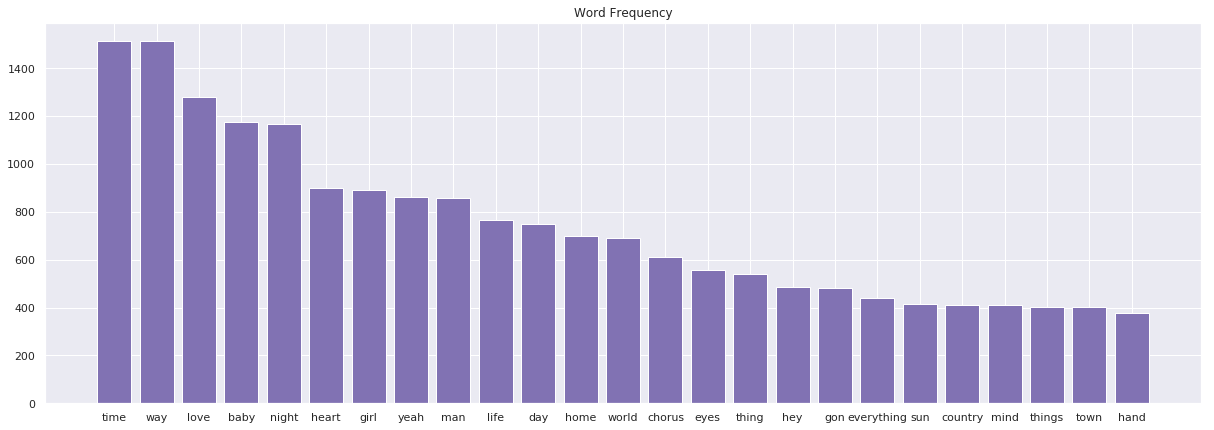

In [8]:
# Get rid of any oddball singal charcters (yes, it filters out 'i' but thats not a super interesting word anyways)
noun_frequency_country_long = noun_frequency.loc[noun_frequency.keys().str.len() >= 2] 

# Plot the global word frequency 
pos = np.arange(len(noun_frequency_country_long[0:25]))
fig, ax0 = plt.subplots(figsize=(21, 7))
fig.subplots_adjust(left=0.115, right=0.88)
fig.canvas.set_window_title('Word Frequency')
ax0.set_title('Word Frequency')
rects = ax0.bar(pos,noun_frequency_country_long[0:25], color='m', tick_label=noun_frequency_country_long[0:25].keys())

<BarContainer object of 10 artists>

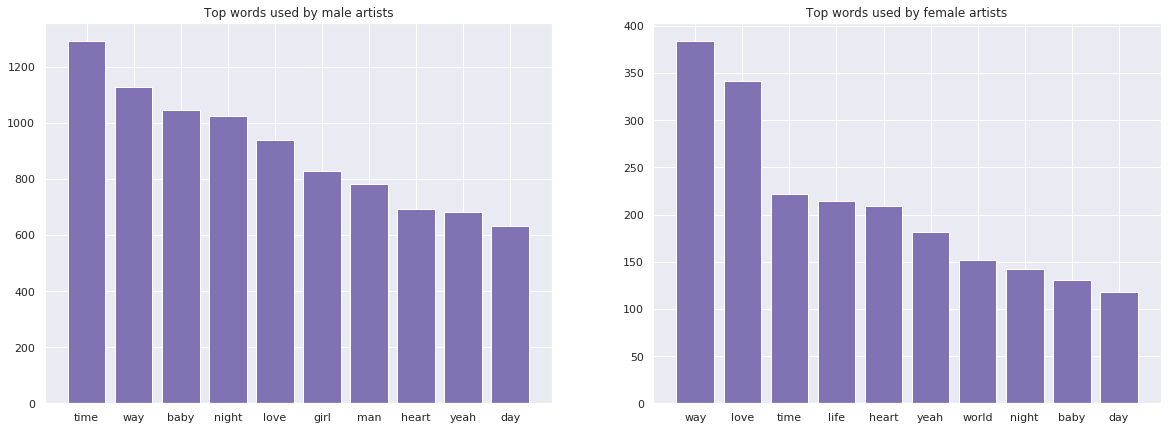

In [10]:
# Remove the female artists to see if there is a difference in popular nouns 
male_artists = noun_df.loc[~noun_df.Artist.isin(['The Band Perry','Shania Twain','Carrie Underwood'])]
word_frequency_m = male_artists.Lyrics.str.split(expand=True).stack().value_counts()

female_artists = noun_df.loc[noun_df.Artist.isin(['The Band Perry','Shania Twain','Carrie Underwood'])]
word_frequency_f = female_artists.Lyrics.str.split(expand=True).stack().value_counts()

word_frequency_m_long = word_frequency_m.loc[word_frequency_m.keys().str.len() >= 2]
word_frequency_f_long = word_frequency_f.loc[word_frequency_f.keys().str.len() >= 2]

pos_m = np.arange(len(word_frequency_m_long[0:10]))
pos_f = np.arange(len(word_frequency_f_long[0:10]))

fig, ax0 = plt.subplots(1,2, figsize=(20, 7))
#fig.subplots_adjust(left=0.115, right=0.88)
#fig.canvas.set_window_title('Word Frequency')
ax0[0].set_title('Top words used by male artists')
ax0[0].bar(pos_m,word_frequency_m_long[0:10], color='m', tick_label=word_frequency_m_long[0:10].keys())
ax0[1].set_title('Top words used by female artists')
ax0[1].bar(pos_f,word_frequency_f_long[0:10], color='m', tick_label=word_frequency_f_long[0:10].keys())

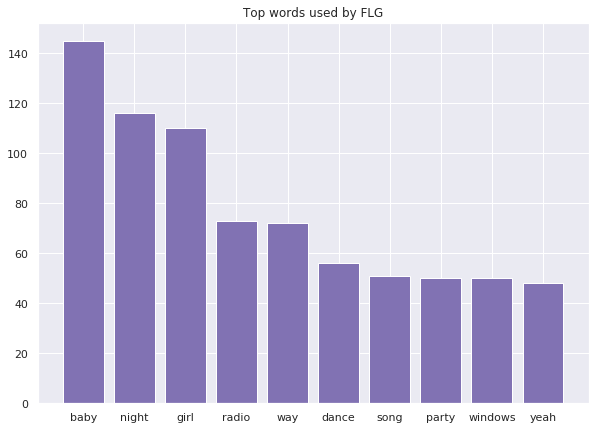

In [11]:
# FGL specific analysis 
artist = noun_df.loc[noun_df.Artist.isin(['Florida Georgia Line'])]
word_frequency_artist = artist.Lyrics.str.split(expand=True).stack().value_counts()

word_frequency_artist_long = word_frequency_artist.loc[word_frequency_artist.keys().str.len() >= 2]

pos = np.arange(len(word_frequency_artist_long[0:10]))
fig, ax0 = plt.subplots(figsize=(10, 7))
fig.subplots_adjust(left=0.115, right=0.88)
ax0.set_title('Top words used by FLG')
rects = ax0.bar(pos,word_frequency_artist_long[0:10], color='m', tick_label=word_frequency_artist_long[0:10].keys())

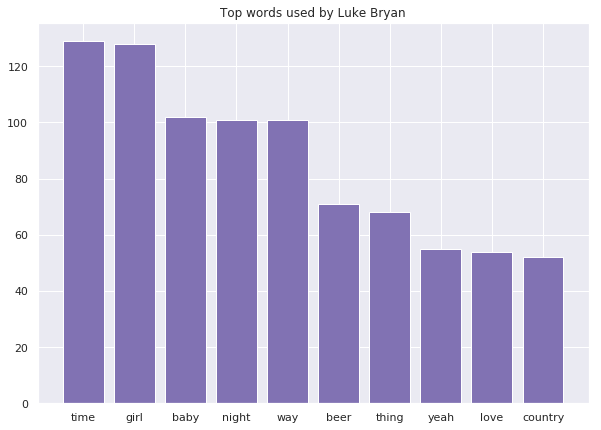

In [12]:
# Luke Bryan specific analysis 
artist = noun_df.loc[noun_df.Artist.isin(['Luke Bryan'])]
word_frequency_artist = artist.Lyrics.str.split(expand=True).stack().value_counts()
word_frequency_artist_long = word_frequency_artist.loc[word_frequency_artist.keys().str.len() >= 2]
pos = np.arange(len(word_frequency_artist_long[0:10]))
fig, ax0 = plt.subplots(figsize=(10, 7))
fig.subplots_adjust(left=0.115, right=0.88)
ax0.set_title('Top words used by Luke Bryan')
rects = ax0.bar(pos,word_frequency_artist_long[0:10], color='m', tick_label=word_frequency_artist_long[0:10].keys())

Artist, Num_songs, beer_count
Luke Bryan 97 71
Toby Keith 236 43
Blake Shelton 132 24
Tyler Farr 21 23
Brad Paisley 160 23
Garth Brooks 226 21
Tim McGraw 198 15
Eric Church 61 15
Dierks Bentley 101 10
Florida Georgia Line 52 5
Zac Brown Band 0 0
Gavin DeGraw 68 0
Jason Aldean 0 0
Sam Hunt 15 0
Thomas Rhett 0 0
Midland 1 0
Keith Urban 146 0


Text(0.5,1,'Beer Frequency')

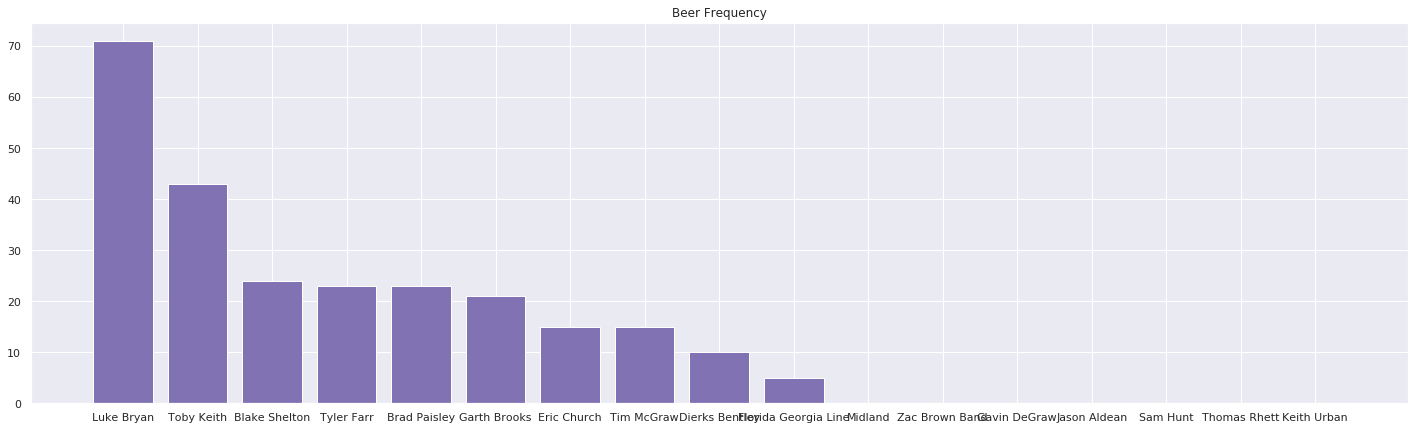

In [13]:
# More elegant function based beer analysis... 
# What is the usage of the word "beer" by male pop country artist?
#
maleartists = ['Keith Urban','Gavin DeGraw','Dierks Bentley','Eric Church','Zac Brown Band','Sam Hunt','Tim McGraw','Garth Brooks',
          'Jason Aldean','Brad Paisley','Thomas Rhett', 'Toby Keith', 'Florida Georgia Line',
          'Tyler Farr', 'Midland', 'Blake Shelton','Luke Bryan']

beer_series = single_word_count('beer', maleartists, noun_df)

print('Artist, Num_songs, beer_count')
for artist in beer_series.keys():
    if artist in noun_df.Artist.value_counts():
        songcount = noun_df.Artist.value_counts()[artist]
    else:
        songcount = 0
    print(artist, songcount, beer_series[artist])

#print(beer_series.sort_values(ascending=False))
pos = np.arange(len(beer_series))
fig1, ax1 = plt.subplots(figsize=(25, 7))
fig1.subplots_adjust(left=0.115, right=0.88)
fig1.canvas.set_window_title('Word Frequency')
rects1 = ax1.bar(pos,beer_series.sort_values(ascending=False), color='m', tick_label=beer_series.sort_values(ascending=False).keys())
plt.title('Beer Frequency')

Interestingly enough, Luke Bryan uses the word "Beer" more than any other country artist included in analysis. We should look into the titles of his songs and look into the distribution of the word among his songs. I expect "Drink a Beer" accounts for lots of "Beer" usage haha. More to come later... 

artist, Num_songs, Truck_count
Toby Keith 236 35
Tim McGraw 198 34
Keith Urban 146 33
Luke Bryan 97 29
Garth Brooks 226 27
Blake Shelton 132 21
Dierks Bentley 101 17
Florida Georgia Line 52 15
Tyler Farr 21 11
Sam Hunt 15 10
Brad Paisley 160 9
Eric Church 61 8
Gavin DeGraw 68 1
Thomas Rhett 0 0
Midland 1 0
Zac Brown Band 0 0
Jason Aldean 0 0


Text(0.5,1,'Truck Frequency')

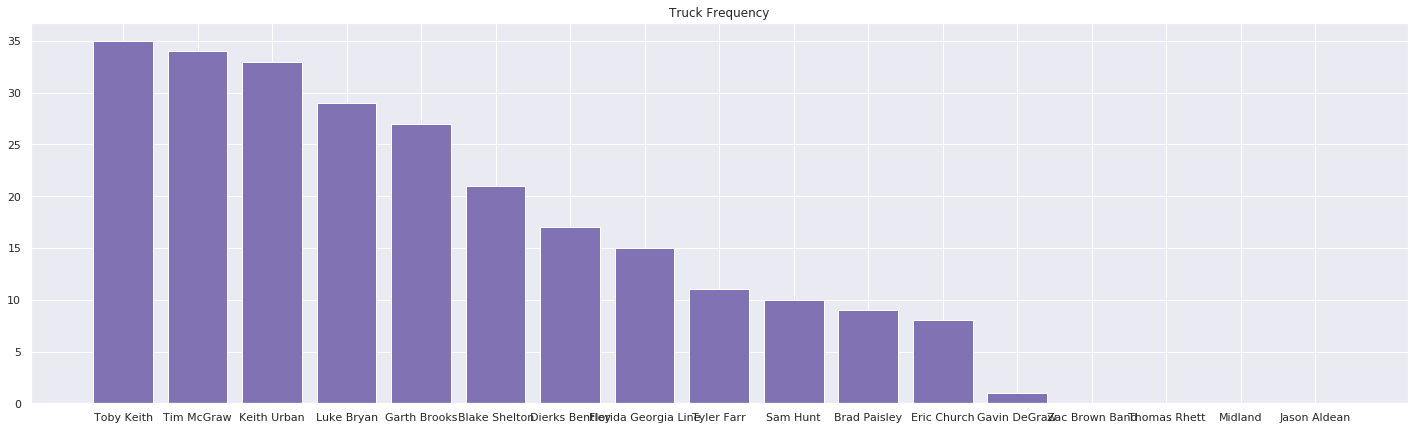

In [14]:
maleartists = ['Keith Urban','Gavin DeGraw','Dierks Bentley','Eric Church','Zac Brown Band','Sam Hunt','Tim McGraw','Garth Brooks',
          'Jason Aldean','Brad Paisley','Thomas Rhett', 'Toby Keith', 'Florida Georgia Line',
          'Tyler Farr', 'Midland', 'Blake Shelton','Luke Bryan']

truck_series = single_word_count('truck', maleartists, noun_df)

print('artist, Num_songs, Truck_count')
for artist in truck_series.keys():
    if artist in noun_df.Artist.value_counts():
        songcount = noun_df.Artist.value_counts()[artist]
    else:
        songcount = 0
    print(artist, songcount, truck_series[artist])

#print(beer_series.sort_values(ascending=False))
pos = np.arange(len(truck_series))
fig1, ax1 = plt.subplots(figsize=(25, 7))
fig1.subplots_adjust(left=0.115, right=0.88)
fig1.canvas.set_window_title('Word Frequency')
rects1 = ax1.bar(pos,truck_series.sort_values(ascending=False), color='m', tick_label=truck_series.sort_values(ascending=False).keys())
plt.title('Truck Frequency')

As expected(?) trucks also seem to be a prevelant theme in pop country analysis. Neat. 


# Similarity Analysis #
Now that we've looked at simple word frequencies, lets do some similarity analysis to see if we can find anything interesting.

In [18]:
#
# Start by making a one-hot encoded frequency array of the number of each words in each song
#
from collections import Counter

noun_frequency_array = np.zeros((len(noun_df), len(noun_frequency))) # [num songs, number of possible words]

noun_dataframe = pd.DataFrame(noun_frequency)
noun_dataframe.insert(0, 'numeric_ID', range(0, len(noun_dataframe)))

for index, row in noun_df.iterrows():
    lyrics = row.Lyrics
    song_word_freq = dict(Counter(lyrics.split()))
    for word in song_word_freq: 
        noun_frequency_array[index][noun_dataframe.loc[noun_dataframe.index == word].numeric_ID] = song_word_freq[word]
noun_frequency_array.astype(int) # enforce int type for our array

#
# Use a cosine similarity to compare how similar any two songs are (based purly on the nouns they use)
#
import sklearn.metrics.pairwise as skl_pair
similarity = skl_pair.cosine_similarity(noun_frequency_array)

# First lets look at the similarity of all the songs
s = 0
count = 0
for i in range(0,len(similarity)-1): # Similarity matrix is symmetric so we only have to interate over "half" and skip the diagonals
            for j in range(i+1,len(similarity)):
                s = s + similarity[i][j] 
                count = count + 1
print('On average, every song has a similarity in noun usage of:',(s/count))
print ('')

# Now lets look at the similarity of songs by a single artist
for artist in artists:
    artist_songs = noun_df.loc[noun_df.Artist == artist] 
    number_of_songs = len(artist_songs)
    index = artist_songs.index
    if len(index) > 1: # If there is only 1 song present you cant compare...
        s = 0
        count = 0
        for i in range(index[0],index[-1]-1):
            for j in range(i+1,index[-1]):
                s = s + similarity[i][j] 
                count = count + 1
        print('average similarity of nouns used in',artist,"songs is %4.3f" % (s/count), 'using a sample size of', number_of_songs, 'songs')

On average, every song has a similarity in noun usage of: 0.19822475751500696

average similarity of nouns used in Keith Urban songs is 0.275 using a sample size of 146 songs
average similarity of nouns used in Gavin DeGraw songs is 0.262 using a sample size of 68 songs
average similarity of nouns used in Dierks Bentley songs is 0.229 using a sample size of 101 songs
average similarity of nouns used in Eric Church songs is 0.243 using a sample size of 61 songs
average similarity of nouns used in The Band Perry songs is 0.301 using a sample size of 29 songs
average similarity of nouns used in Sam Hunt songs is 0.291 using a sample size of 15 songs
average similarity of nouns used in Shania Twain songs is 0.234 using a sample size of 134 songs
average similarity of nouns used in Tim McGraw songs is 0.227 using a sample size of 198 songs
average similarity of nouns used in Garth Brooks songs is 0.118 using a sample size of 226 songs
average similarity of nouns used in Brad Paisley songs i

Interesting to see that there is a cosine similarity of almost 0.20 for nouns used across all songs included in our analysis. Does this suggest that all pop country music is thematically similar? It would also be interesting to see which artists are most similar to each other... More to come

# In progress
A silly way of visualizing frequency data...
Plotting the histograms with custom images, like beer cans and trucks

In [ ]:
# Read in images
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICAgLCgoLDhgQDg0NDh0VFhEYIx8lJCIfIiEmKzcvJik0KSEiMEExNDk7Pj4+JS5ESUM8SDc9Pjv/2wBDAQoLCw4NDhwQEBw7KCIoOzs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozv/wAARCAEsAJ0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2KeZLe3knkOEiUux9ABk1xL/EyFjug08+UfutJLgkfQDj867eSNJomikUMjqVZT0IPUV43qXhexs9au7SKe5NvE+I0Mn3Rjp700JnTSfEqUcpbQAehJNQt8R7xm+VIFHoqn+prn4fD+nE8xu2PWRqvQ6BpY/5c1z6kmtFEy5i83xCvSSPMAz02hRj9KjHjq43fNcyH23gf0p8Gh6YefsEP4pmtGDRtNBGdOt/xiFPlRLmUF8dpu/eSynPPE7D+RqwnjnTSP3gmb/t5f8AxrodP0vT9wxp1rj/AK4r/hWyllaR/wCrtIU/3YwKl2RpFN63OLTxjocn34ZOfW4c/wBalHibw0/LIB9Zm/xrsvJh/wCeKf8AfIo8iD/ngn/fAqboqz7nIjxB4YI5CD/ts3+NP/tjws38af8AgQ3+NdYIogMeUgH+6KTyYR/yxT/vkUXQWfc5Q3/hpvmDr/4Et/jUT6poq/NDdSIT/dvG/wAa7DyYv+eKf98imtaWrfetYj9UFHMg5X3ONPiCzQfLqVznti5z/OqNx4luFObfV5h/vMrf0rvTptg3Wxtz9Yl/wrH1LS9MDEf2ZZ/9+F/wqk0yJJpXucY3jLW42JTUw3s0aH+lKPiF4gg6m0mA/vxHn8iK1LrSdLPP9m22PaIVkz6JpZUhbKNeONuRV8iIU/M6HwZ47n8R6tNpl5ZxxTRw+cskRO0gEAgg9Oo712tcX8ONNsLaxu7iGBRdmYxySHliowQPpXaVi1Zm62Gsyohd2CqoySTwBXl806X1/dXucpNMzJn+7nj9K2viJ4ljsLRdJiYmSfHnbTyE9Pqf5fWuIPiO1RAi2s2APUUueMdzSNCpUXuK5vo8aCp0vY0X7vNcv/wkVuf+Xab8xTv7fhI4tZiewBFV7WHcr6jiP5Tq49Yii6RA+pzSnxLt+7Av51yDa1ngWFyP+A0n9rEkf6Bc/l/9an7SJP1Gv2O1TxnPAPlt4/xqVPHl2fvWsP61wramzf8ALhc/98n/AApBqEhOfsFz/wB8n/Cjnp9R/UsStl+KO+Hju472kX5mnf8ACc3B6WkP4sa4Jb+btp9z0/un/ClN7MR/yDrn/vk/4Uc9Mf1LFdvxR3J8eXPa0h4/2jQPHl0T/wAecOMZ6muFN3cEY/s66P8AwE/4UourgY/4lt0f+An/AAo56QvqWK7L70d2fHdx/wA+kWP9401vHdyOPs0X61w5vbnGP7Muf++T/hTWvZz/AMwy6H/AT/hT56QvqWK/po7WTxzdNwsaj6CqkviyaY/MuTXJm8n/AOgbc/8AfJ/wphvZ/wDoG3X/AHyf8KaqU0S8DiXuvxR07a2ZQe2fWmW16szyKw5VQ49wCN36En8K5r+0Ju+m3X/fJ/wpU1SaF1kj0263Kc8qefbpT9rAn6jiO34o9B8ByeTqGq2TnD7lcD1AyCf5V2leLDxUdOvrXUre0ulmhO2RWTgpgcZ75Xr9K9isL6DUrCG9tnDwzIGUis5NN3Q/ZzgkpKx4r4ilN2b3U3y0huxFljnaCGP/AMSPwrBVu5rq2tft1l4gtVALrOzJj+8hz/JSPxrj4yGUEVy1Vrc9vATTg49iypGO1T2lyLO9gu+f3Lhjt6474qqvSpFx6VlselpJNPqe0x6gLuFLmCfzIpRlWU8Gni5k/vt+def+BdZEE7aPcP8AupTugJ/hb0rucYYg9RxXoQkpRufI4ijKhUcGWDd7CivMQZG2xqMksevAHJ45q3blLiPzI7wsuSMg9CDgg+4IP5Vy+omeXxDZK9wLC3tQJoZ9hYzuchkGOvAUbe+c9qi1m38Q6qwMdklrEbZ43tmkUKS4G5hg8vnpnHHfmk2XCkna7Oz2RqMm7OAMk7uAPWoftmn5RRqcbNInmIBKPnXOMj1GeK4o6Xrv2eWygsDBp0q+W9qtxGMR7h0/2igx16k+lRRaBr1pMkwtILyeExrEWmURrEF4QA992Mn296V2aKjG2slc7xpYkljie8CSy58uNnAZ8DJwO/FOcrGpZ52RVGSzOAAK4i30LW8fbJ2Mt5A5NsHnG47mLOWPI/urj0q0lj4imWKG/la4ieSN51MyBQc5ccc7eBgDtmndidKK2kdcY2yVEx3Dkjd2qNiyKWacqqjLMTwB61ialBrV5qrGwmWztcRr5+5d5wxLHGDxz0PXA96jtvteoacbC5R93nOJ5JSSuwMSqZIGcnaOM8Z5ouyPZqydzSTV7CWWGJNTQSXEPnxqzYPl4zk+nHr6Gp2MnlrJHciVHAZXRsgg9CDXCromqWlwbGK2JaSIJLLG22OQEAn5iMcZcAHpxU8ei+KLeHyYbpIoowQqR3XDA54HHy4yOfQUKT7FzoQ6SOruLw2sfmXFx5SFggZmxlicAD3NRXl+LCDz7uZoo87dxyeewrlbzw74kvTH591b+XE4kjX7SxwVGB/DjPI59vepP7E8QTW91He38c7zeWEMtwzKADl+NvBPPPuPSnd9jN0oJL3za/tSGZkMVwS7jcnXn5Q3P/AT/Os3wfqH9i3+s6Wi5toZ0khQdIw67iB/L8Kht9DuLK+hu3uxIsagGLjA/d7CB8uTgBADnkA0vh+MS+JNeJ7G3x/37pvbUzSSdou5naY5i1/WAAMLdk4/4E1chq1j/Zus3VoowgfdH/uHlf0OPwrrrYFPE+uoRj/Sc/8AjzVR8aWXmWtrqcY5iPkTfQ8ofzyPxFY1I3hfsd2Dq8lflfU5dSMVIKiU/lUgrkPooj1LKQ8Z2uhBU+hFepeH9aj17TRMPluIcLOnfPrXlinv0rX8O3l3pesx3VvExjdSJFYEK649a1oyalY4cxoQqUue9mj1KN2XhSQD29aLuaK0bFzKsbBN+0nkj2FcpZ+K4rjVGsZ72MzHlYIl5LDnYD69sZrl73x3e6z4gWW4toLeGUiNFwSY88KSe5BIzXoxpyZ8yrtHoSa/EZPnt5BCf4gQT+X/ANeqUvieVL4wL9lBU/6hny5/X+leU2FzqcOspdM91K0Uw89lLMOD8wPt14ofRNUNzLcx2kzhJWPm92wevPJrT2S7g4vue02+s2tws2biC2kCkxQySje3GRx1q1p92b5IyImDEkOMHgj0ryG48Oa1e3Gp6jBpk00PnO4dfvYzxgdcYqtq9zqUesvcpNfRRWpEUM4LqFKAKSD7kE/jR7FPRMFc9viDPtzGyEn7rDFOl3Byr9RxivN7zx3rFnILEG3uPssaC4aVSWkk2gvyDxg5H4V2GieI9EeS3try6MN7PCkjwTEnYW5ALdAcEcVjKnKKuxppuxpFj07UxjxVeK/iaSSK4kjhmjlaPazY3AHg1OwI4PWpJY01Gx5609jTG60xFac8Vm+EkM3iLxER/DJAP/HDWjcHANVPAal9b8SN/wBPEQ/JDSlsXBbmKBt8aa6uMZlz06/Mf8a0pbSPULKexlICXCFMn+E9j+Bwaz5iR471pSe+R7cg/wBa004wSKmOqLm2pJo8x8uSGR4ZlKyxOUdfQg4NSLW/4204wahDqsY/d3g2yY7SqP6jB/A1iW8JuJRGDgYyx9BXDKDUuU+oo14ype1e3UmsrQ3EiOxVYlYFg38QHWneI/EF1Z6+6WyoEiCliwzvBAPHoMHtWfq08ctqbG0mLmFsyoOrKPfocHrW/wCFPAd/rdra39+8MVgnzwE/Ozr6Ef3c8816FKnGmrnz+KxEsRPmlstkZWieHLjVNS+02F2LSzTE63kp5Q5zj6g59uM1o+IL/wAJ6brN0bWFdWuJW3vIoxCrHqF7Yzk8A/Wupv7zwRpxS31O8jvnj6QgGYA+6oNv51DP4t8Az3YtbvSYirYHnPYqFH5cit1KTd2jk9ThpfFmpSKRbLBap/djTPPcnPeqja3q7kk383/ASB/Kus8ceCLLTNOXX9BJFnkefBv3Kqt910J5xngg+tcMOVrop8kldItJG5pfiPXrS3mFvq1wgI5G4EH86ksPGOswSETGC7jOdyTRjDflisW2lVY5V7kYogHzHnFaezj2Ie7O80/VfB2tWwg1nSjpk/mbzdQjKsc5O4jk59wevWph4Nuo7h9Vn1CK/wBOvA0s93bjmMAljgD1HAx34NcfaL+4Yd63PB+r32hX0j2cuYnGZIHzsf3x2PvWMqbSbgyOZbMr6f4tvNT1+SG4jQ2lyWEahRmFQDglu+AOSfeu80nXYrhrfTpFO/ZtinDblkx6+nH1rgtVit9Zs9S1rw+qwGYltQtTw6AckLjjBPJ9cVV8N6gNH8iOabyrh5RLbAjIT69hk4rKcU1dFtdUeut1xTCKisbtr60851CyK5RwvTI7ipDWBBVuvu1B8Ofm1TxKT/z+KP0NT3XSq/w05vfEbet9/VqmexpT6mPcqP8AhY2rqejLn/0Gsvw/4lury+g0+9UmSZ2AlMJQAKhIH+8xBP0HvWjqAA+JeqA8Boxz+CVFp2q6ld6/JY39qYYoDN5EnlMqzDICtk8ZAB6HkNShsXM2b/TV1fSbjTmIDSjMTN0SQfdP9PoTXn0Usemac17co/mhjH5fQg5xt+uQa9LthvcLnHOK8y8V6pDdXssU1sUaZzMxTgpyQDjvnvT5E5cxUK01TdJbMydPsYrm980zMLaPMrtnDJ3wfT61PqHiLUb+3NjHcyW+mqcpbRttU9vmx16dDxUUxFno8dshy90xd2AwSg6Z/wA9jVJY2mljgjGWlYIB7muiCXUha6npnw7gtfD3hK/8RXUSbSGcbh1VegH1OB+Nef8A2e917VDFbQPc3dy25ti5wSckn0HWvWtS1DQvCmm6bousoZIpYsCMRCRflxksD23Hj6VBb+M7CaWWz8JeHrjULhfvGKFbeEf7zdf0ojUkrytuRfUh8WFfDfwvTSbmUPczolsgz947gzEewA/PFeT8hAFGWPAHrXT67pXjfX9ddtT0qeS5iTMcMQHlxRn+7g4P1zn1qr4P0c6x4tt7OVf3cDF5/wDZC9RWtJqEG7lrRHZ6tFbeEfhXHa+TF9uvwsYYoC2W5Y568L+pFeb2wC/eNeheP9J8R+KNZB0zS5ptP09NiNlVEjnlioJGeNo/4DXn8SEXCwvGwl3FDEQdwbONpHXOe1Vh2uXfUl7HV6b4P8R3Fkk8emkRTKHjLSIuVPQ4JzXR+EPB13YatLda9ZxfZ1iIiiYrKGcnqQM9Bn86panrXjzRLSKXUpltY5DshCxQk9M4AAJHFdJc6jqWg+BmvtWuDLqrrhSyqCkjnCrgAD5Rz+BrGc5tWutexCS3OD8UWuoeEPFj6tHbWtrZ3zusFpbkYeFcA7lAwM5z9TWFq1nZxX0d/FK32OcCZQTlmbuo/wAT0qtd319qMrSaheTXcigqrTOWKj0HpVvTcX+kXWmyZzCRPEQu5gM/NtH9PetXFxSuaX6nc+E/EEmp3yJEGW2uQ++BufKcDOQfoK65F3NjsOp9K8i8P6wbW58vT0aEwfvEYnLScgEN25z0Fdr4tl1Ea5BBZXl3Bbx2pnuIbfOWPmAAYHJJyfwFcslZmdtRNC1C71I3kt1cmaFEi2Hy9iK53bgD0J6dPatf4aj95rret6f/AEJqwtTi1DV9d0/U4NOlW2iKOI7pxH5Sg91JzuBBPTuK3fhoQ39tsDkG9P8ANqzmawW5ha0NnxPvh/et1P6D/CtJXJTbniqPiTj4myD+9bj/ANA/+tTtRv10jSZ9ReEzJAATGrYJBIHX8aUOoVOhotObe0muFXc0MbOq+pAzXk+s3a6nrEiTo7T5CeYhGSfp0xzXYQ/ErQJLeUCO5huChCJLEGQk+pB6fhXGfarWXW0mCBF8wYm34Bx3II9qtEpWI9Wk8zVJAMYjAQAdBgVvfDnS/wC0/F8UjJujsl85v97+EfnXMzv5l7PIDndITkdDzXTeFvGUHhPT72KLT3nvbofJP5gCoQDtyMcjPP4VpryuxXQn8QOfGPxNNjFJmCNxaow7Kmd5H1bdXTeNPFUXgy0h0Dw5bxxX06bsqmRCp4Bx3Y44z0rzzw1qP9ha/aai6tKsTZkAPLAjn8a7jV/H/hcT/wBp6dov2/WVTZDPcxBRF6ZPOcZ7D8RVyi9Fa6FbU2H1fVfC/wANJL/Wbt5NUMRETSHLB5OEB9x1rP8Ah7pUfhjwneeJdVVlM0JkwfveUvP5scVBH8RtAvNCiTX9Pk1C+TDPA0KmOSQdGBPC9fSq+lfEe2v31C28VW3+hXmFjiiXckUYGNmP1z61moys1YNS18PNZ8ReKfEt5ql3cSGyRCBbqcRIT91VHt6+1PudV8Jaf4umv9JLax4hvpwkaL/qLdz8pbOB9e/4Vl654+sbfRDoPgyyawt3BV7ll2kA9do5OSP4ic1L4a8S+CdNsLOS50VodTsVwsscW4yH1zn+fSr5G/esB2t+9m3i3SbO/QzzxwPLbqFyolJA3EewVjz/ADrB8e/btd1zT/DenJ51wiNdSDOACcgZPbAB/wC+qyIvFU0nixPEdxBmMDYtuGyUiwVwD685+taWs/ESyijn/wCEfsmXULhdkl7NGqsqjp0yWx2z0oVOcZKyI5k9Dze6gmsrye0uU8u4gcxypkHawOCMjg1Z8PT+R4htGJADvsP48f4VRIOXLMzMSSzsclj6mnWjiG/tpi20RyqxPpg101L2szTdGlauNP16SxjgKNvaNpGbL5B6gjgDI9K9c027nudHs7idj5ssKu5/vHHX8ev415Fd6hax+I5rmJEkhaViZxkkg9wDj+VdKnxRhttMggXSpLm4hjCGV5QitjgcAHtiuOadyJRb2OznbLcnvTPhcM2eqv8A3rw/1/xqG1uGvdNs7x1CPcxJKyr0UsM4FT/CznSL9/712T+grGZVPZmN4q+X4lof70AH/jjf4VV8Urv8H6mOv7oH/wAeFW/GPyfEa2OM7oR/6Cwqv4hG7wpqn/XuT+opR6lT6GJDrS2/w40vU7zSrDUZFuxaOLi3U5iG7HI5zgDmkuvD2i6J8RrfSbmw+2aVqkamCJ5GBtyxI4IOTgqfwNQaV/ZTfC+D+3DcixTU/mNrjerdjz25Oe9WNfm1FvippT6gkSRB4hZNCSVeDccNk85yTmrRJg+LtOtdH8V3mn2KGO1i2GNCxYrlQep56k1ldTXe6x4Wj8V/ELVLNdTWyu444njjaIuJV2DJyDxjj86wtD8G3Ov2Vzc2ep2iy2bMJraTcHG3OD0xzitYNdSk9DCXhhSHg1u6J4R1DX7STUY57axsYjhri6fauar674Z1Pw6IZbzyZ7S54gu7aTfG564z1B+tdHOtgL3hLwlZ+K1mj/tf7JexfN9n8jdlfXORV+D4f6fqd5d6ZpXieKbU7MlZIJ7Zo1yDg/Nk9/QGj4UkDxVOT/z7NzWzo/h/U9K+Imq+I9StxZaQrzy/a5JF2lWJweDnv6VlKbTeornE6Z4Z1XVNek0GOFIb6BmE/mthI8dSSM5H09auweGY7LxSdA8Q3v2KTA8qaBfMWQn7uM44PvV5dY1PW/iNeat4QMbSSYWLziEWZFULnDY646dap6iNZXx7bN4j2f2iZY2cIQVVP4QMcYxWqlNu1+gnsafiTQ4/Dmox6fDO9wphEheQAHOSMYH0qx4N0DQfEk01rfveLfRkuViYLH5eQAc4Jzmul8T+FLzxBr32mK6t7aFIBGplJLOQSThRzgZHNZngjTbnQvHF/Y3aq0sdqGDRnKupYEEVDqXp76maVmebXkSwX93boSVhmeNSepAYgVXzyM13T+Abe/i1i5tfEEE+pWrSSTW0aEpGcltpbPXtx3qjYeH9C0/wxY+IPEkl3KdRmEdta2pC4HPLH6Cm6qaRqjkZGC/Q1ESCrAHp1r0y18HeHrPxZf6Ve2015bfYRe27PKQ0S8hlO3GTxwa57xMdOv8A4f6Rq9npUGnStcvBthHLIBxuP8R4ByfesXNN3BM77Tvl0LSx/wBOkX/oIq78K1P/AAjlwx/ium/9BWqdrhNG072s4v8A0AVofC0f8UmT63DH9FrCe4U9mYPjgbfiFYsehhX/ANmH9ag1r5vDOqjt9kkP5DNW/iH8vjXSG9YlH/j5pHhS5tZrWXPlXCNG+04O0jBwaUeo59DkLPRNSvvhIbWztzd3E94J44YDvYJ0yQOlaXi7MfivwhaY33dukfmovJQbhjP5NVY/DdYZfN0jXJ7Z+3mL0/4Ep/pVG48L+KfDdwdcg1CCSZDg3SSlnG7jkOOfStEibo66zIT44Tg8F7BSCe/yj/Csr4bKU1jxPCQQy71I9PnYVy//AAl3iG81ex1GS4We+stywkQKpYHqrBQMj+WTW/b/ABHvLLVJp5fD1lBJIP8ASEiUo8rf3mY5J4/nVJPoDRoWQsZvgyF1F547Ikea1uoLj94MYB4POKy9Y17S5/h5BoWnwajKkEyNHdXNvsTAJ/iBIzzik0vxbp9rZ32lXWi+bod25ZLRZTmEHkqGPPUZHIxVbXfFtne+GovDWi6U1hp8cgdjLLvc45A/P37VahJPYE7stfCnH/CWSrwc2zVo6FquoJ8Xr6ya+uJLR7iZPIaQlAM8AA8DFYPg3xLpXhaWa6urC4ubyQbUkicAKnfg96mk8U6TD44h8TadptxCrEtdwyOMu56lfT/GqlFuT0BrUn1Wzt7D4wJFaxLBEbqKQIgwFLKCcD65qfxyf+LrQ89BBmqmo+KtEv8Axta+Iv7Nu1ihjHmwlwGkkX7p9AMYz9KXW/Fuia14lsNb/se4V7Y/6QrSgGcD7g44GOaaUrrToFjsdaP/ABdTRxuPEagDPABL5rQsgW+KN3/s6ZH/AOh1hwePtIvbxNVn8PubmNSkUwdTIvqPTHPB69aoW/jqa01TUNSbS4pZ7wqFJkI8qNRhVyBz6/Wo9nN9CLrqN+Hx/eeMHAO0JLuJ6Zy5qvrNndXnw48IC0t5LnE4DCJS20nOM46dKp3fjvXNQsrjSYLS0he/LLLJbw7ZJNx5Hp04z1rNsfE3ibwxF/ZlleyW8THCx7Efn/ZJB/Sm4Svd7lnorW0t18RNTWIZEGirA7E4VJGyQpPbrmvPtSe1f4Wafa/b7dL3T72QS2hceY2TjKgdQOuelaGm+ANR8QTXM15rRiYyAzthnaRyM85IHHvV3Q/CXgm81C7to5LvU7iwO2YzN5cTHpldvJAPvWbVhXSOmT5NIs+220j/APQBWn8Lxjwch9ZnP8qzb0hLWRVAVI4iqKOwA4FanwybPg6IYxtlcfXpWM90VT+EwPiaNvibRJOxKr/4/T0p3xWAW80SUdVnH/oS01eG4ojuOeyLCdKmkgiu7WS1uFLQyrtYZ/Ue4qGP3qymcVZkeY+LdOOkXbxWwxEWKyyhcM4IBXPsefrQYG1zT4FKCPVYY8qpODcRdifQ+mf5V6NqOmW9/G1w0RNzEh2hekmOQGHevLr7Tr+11SS8SRo4i5kW6BzsXrg/TpitIMtaoqxnqjqVZSQVIwQabbRrLqMcLIXR2wQvWt5JtN8UJiaVbDVQdqSMPlnHbdjv61g3lvd6ddNHOhjdSQHU5B+jCupzTVupMd9S1eWNukV28SsrW7ADk9M99wH6Us1tbRLFiORxIisYlf5yT6cc1nSXE0ygSTyOo7M5Ipwu7ofduph/wM1nr3L5WW7S0gl077RIuHEmzLMQp49gals7SCeW632ciLFD5iq7N8pwOuOSDms9J5o1CxTSIo/hDkCl+0TAsfOcF/vnefm+vrVqL7g0zrdQ023sNC0m9tISEvEZpJUYtCzcYC5+YHr1rHlcIueueg9ak0myv9TZLTTreW6brsTJVPc9hXSm30rwVG097JHqWvlSYIFUmG3bkZJ6Egg/4d6rm5Fy3uzBq7uZUFm/huzNzcKn9sX8ZFpBIf8AVLxkn0Yg8Z+lZ/hWC5bUd8qOU3YUOOshPUZ79efepbnSb/xJO+rRTtNDLzNJM+WhYfeQeoGeMV3fhSzge0bUJI1e4SQxxMc5jAA7dMn1rnnLvuzZ7G3BBDp8Yhtkwikk5OSxPUk+tYeh+GoPD0l5LHdSXMl0VALrjy0XovueBzx0FbrGoXPBrEyMzUmxZXJ9IXP/AI6a2fhou3wdCf70rn9cVhaucaZeH/pg/wD6Ca6D4cLjwXae7yH/AMfNZz3N4fCYfxbXEGlSDtMf5qahQ/NVv4tj/iUWL9lmP8h/hVJGy340o7jn8KLSGrCGqqGrCGtDEnabyYJZ/wDnmjN+QzXll/qYj1ie3udz2rxrG69gcZzj8a9I1STZpMw/56FU/M8/pmvHrqX7TeXE3Z5GYfTPH6VcFdsuKLwtYrayuJ9PmN0xXy845jU9ce+OPxNQW+o3S2x8xxLCmFWORQQSe2foDVa2uZrOQyQNtJ4IPQ1d/tGO9RodRUKM5R4wRtNaahZjQdLuMs0UtsB94ocgE+1AsbJwSmogYI6of1NKlraTwvb2lwTJuDZfgN14H5mnLpji3lg86Lz2IYJnsM/400wuH9m2iqS+orgYyUXOM0+JNIhzIUmvFjK78HA5z9PT9aZBprxwSx3EkULTAKm455Bz/SrNvY2mnwyNqdwGSUBBHD97qDkfTFVcPmdFD4n1G60aeHRFGmLa7WMFqg3PCflZicZyG29McNSaVokd14aubvX2msrC3lEsE2394S3D8EEkH5fxH1pbbXNF8Pae6+G/Nn1C4XDXU6/6senIGfpj61k6v4g1XXAi6jdb0Q5EaKFXPrgdT9apRb+FWRne243xBq9lJYwaVokbx2Nu28yNkNI3+fWu18FXv2m3u4s9fLnUf7wwf6V5lL0I4rqPCur/ANkxWl64zCzG2uT3Ck5B/Dis60VCNzVRc9EejMeOKhc8VLJjIIYMpGVI6EVDJ92sDEx9cONHvj6W7/8AoJrp/h6uPBNh7+Yf/IjVyuvHGi3pPeFh+ldb4CGPBWnf7r/+htWc/iN4fCY/xaQN4XiY9Vn4/wC+TWTC27ae5GfrW78U03eECcfdmX+TVyLXGLSLLYwEJI67WXBx7j+opR3HL4TbSp0NUbGdp7fdJjzFYq+OmQf8MVdQ1qYmZ4suvs2j5HBw7j8FwP1avLEGEFd54/uitqIQeqov5kk/oBXCCtKXU0jsNx81DdadTW61q1ZFCEVJax+beRICQSwyR1qLnNXtJQNeM5/5ZoTUMT2JNbDG6jY/dKcfXPP9KoqOc966HxXpT6cluGyWaKOb6BxyPwPH4Vz6cmtaQo7F6HG0VIxz9Kii+4Oakaukwe5XfrWlo37/AEzUbU87QJVH8/5CsxzV7w5IF1gRMflnjZD79/6VzV1zQaOmlLkkpdju/BesG+sG0yd8z2ozGSeXj/8ArVuycjivLrS7n0nUY7uE4kgfkeo7ivQdWvYn0VLuCXZFdldj5xtB5PP0BFedRnzKz3OnH4f2VTmjtIo6+6tod4VORsxnt2/xrtvBC7fBumj/AKZE/mxNecahOX8P3Q5AI3Y7fM4wPwHFemeEF2+EtLH/AE7qacviOaPwmZ8SwP8AhDJ2PRZEJ/PFcGhX7BZO52q9uoaTqF+Uf/r98V6B8R13eCL722n/AMeFcHYwi88P20BIIaBRg9DxjFKPxDl8Jk6F4gj0m4+wX8jFCcSOSGCnHBB7g9iOxFd0BsIGQQeQR3FeS39ukc00F3C0M0bbMsNqsR/iCP8AJrpvCfiN7C6j0fVJAqcIrScMj8ADPcEY5rVGbVyn48ufM1NYgejsT+ACj+tc1Xd6x4Pnvblppw7ygkboW565+6frXPXPhW6gOFnXP92ZDGf61pTkluUYvWmt1q5caTf2ql5Lcsi9WQhgPyqkSDyDmtm01oNB1FbXhyyN5cx24HNzMsfHpnn+dYnQV3XgGzLarAxHFvC0x+p4H6t+lZyehM9jZ+I1n9pgguEXhkeHjtj5lH868yj5Ar2TxFB9p0Obu0TLIPwOD+hNeRywfZ7yaA/wOQPp2q6D6ERehLGABSnkUIcD61a0/Sr7WJzFYwlgv35G4Rfqf6V1tpK7M92Zz8U21uDbahbzD+CRScema6V/CtpZfPqupqMf8s4uCfxPJ/Ko/ten2Py6XYqG/wCe0oyf15/lXFWxVNaHdRw1Wp8KINUjEWozjgKx3D8eapx6q1zbrpMrk2m7PQkoOCSP1/Gkupprq5Eb5d5gfnPyge+fQc/lVa3wkSmNF8pX2PL0LDqcfgP1964qVPlvJ9TqxVZzUaK1t+Z2moEHwxPMi7YpTH5anrtBGK9T8NJ5fhjTF/6dIz/46K8z8SrFF4d2wtuiYxlW/vAkHNepaMuzRLBP7ttGP/HRVS+I4I/CZfjtPM8GagpzjYvT/eFee6Gf+JRan0QD8jXo/jNd3hHUR/0yH8xXmmhNnSoPbcP/AB40l8Q5fCR+I9CTVIDdrO0ciY8xMAhwPQ9jj14rkBLburxM7ybkMcc5XDD2PY9/fp0r0yJipBBway9Z8MjV3a4t737PO3VXXKMfXjBH61qZp2GeFfE0tzbSWmtMRNbW5niuAP8AXxoPm+rDH41o6Z4oOo3dvaXuly2a3yM9jJIwdZ1HXtxXGS6Ze6DJGJopkjZiqmUBkdiMHa445BIPsa09N8U2em3EEN/ZNe29mClpOABcW6nqn91h78dKdrg0uh2c+lWNwpV7cRuf+WkXBH9PzrhvEvg+W0zdwqDH1MsY+X/gQ/hPvVuPx7fwvLFcR2Y2uSjSxOWKZOMlGIzjHatrRfGMV/qMen3MCW0k4/cSRzCSOQ45B4yueevpTV0TZo8vMEizJDIm0uQAex+hr1HwRbeXaXl1jG91iX6KMn+Y/KpNT8IWWpbptOeO3uQclFIaJj9B90/T8q1NF06fTdFgtp0xMu5pcHIySe/0xQ3cG7otvGs8UkDdJFKn8RXlHiC2eLV49iMz3CDCqMksPlIx+VeriWFbhbdriJZ2GRCXG8j/AHetZraMI9QnvLqSOCDeWR2IDYPJAJ6DNVCXI7iRyei+DZLgpJqZZR2toz8x/wB49h9K6jV9JvI/D7RaOwtzD8xt4VxvTuAeue/vUuoa3Y6VbxR2E1pNPPkRbpwIxjHLsM+oGKxrzxjd26iS3ul3lsI0dmUjz3IeQnOPYUp81TcunP2clJLY5FipCNndJMxVSx6YxnJ/EVEfNZGCAK6Z3sxwqAdST+gq5d3CNNlV2ysAZH3h0kl/iZcAYyc8flVTfb/JFKhlAJLRliAx98YPT371hGkor3ketVxkptqk9+nYrqSbZYxC7wIMyMGwz5PTPXH0pSka7vKTYh6JknaPxpyoEGB90HgZ6e1I1Y1avNpHY3wuDdP357m414brwSkROXt51j/DkivcbRPLs4EH8Maj9K+eobh5Ha3IAFxIjMFGACucYH419EoNqKPQYqoO6POxEOSbRleK03+F9QX/AKYmvJPDN7C9qtkXC3CEkK3G8E549a9g8RDPhzUR/wBOz/yNeLadZWl7pEcV2xjkWdlinTqhyO/p0qluYP4WdUnBwRVhDXNC91vRRi9gGo2i/wDLaP7yj3P+P51p2XiHSrwLtuhCzdFn+TP0PQ/ga2RjYo6y1naeJhe69bTXenPbhLYKhdEfPII9ep/H8sHW0tYPE19Db26W1vEgKKY2UMdowPbJyQe9eirvQZHQ8g9jVTUtKsNZhji1G3MnlnMciHa6/j6exyKpCTsedRyDTHLfY2nljAVBjaV4ySwxk8Y9hRqSJM1pAIVa+uUyBboMsx+6P1/SutHga2XaU1KXep43QqQV/wBoZ5PTk+nSnSeGodAtbzV9Nkmur+GJRbmUAmBc4dlGMEhSSOOKq4+ZGf4h0PTPDtjprWscun6vPGHldbkhYtoG4kdepwMEVkWj3kV75mma1eNfqN7SeYdp56tk+/TmnX/kanY6VLLrMt3fylxcpcvgW4yCoBOSQctyM59O1VILffdy7SBbRsTK0eVDqO2TyB9eaFsNE1xC0skeoahJiF5WWSaIeZIWyfvH3xjOe/Sui0vT7b+2rNdUMlzpkoCWpluPM2yHlRx0U+lYC+fLZSgxjy7xzJHCmdqAfKxJH3QMqc9OK0NCV4Xs7bU2mgtYhI6yxIHkQlSBjjp3BHrmqewma95a22geMYIJrFY4bpyLdmbdGEwAMA8q24DP196p32pX8ks1veRQS/ZJmWPUEXkYbkYBxyM8EjNbmk2I1vQZrfUjJJbear2k2/c8bgfMUY543fUde2KuHwtpbSROTc7YFKxL5mdmepyRk/QkjnpS5l1JvY4O8iJkisLVHnnWVkMEYV2K8YOQTluTyM4B+tGs6bcaVqDWc8TqhIeGR/4l9iOOOn4V6Np+j2GkjNjbBJWGGmb5nYHnr2HsMCqfiexs7zR2jv7iG1kjy9tLM4XDenuD0/KsqnvLTc6sNW5JqMvhZ5wTTDUsMU1xKsMUTySt0jjUlj+HWt+y8IFFW41udbaIkAQK43MewJ6D8Mn6Vxwoye57NfH0qeid2Ymm28sl9azBD5RuEj344LE9K+iq8buZbebW9K02zWMQ219EuIzwDk5H1H9a9jrblUXZHj1KsqvvSKWtLu0O/X1tpP8A0E14dp9kL7TJIPMSPE0iBn7ZAHHvmvd9QXfp1yg/ihcfoa8GsLNrm3cQzeTcw3JeDPIY4BwfyoW5H2WbFjq0tn5FrqERtrhnEUYALeZ0AwRwOSPwBqO+n0m+tbu4i0p7i5tsGYR/u22lsBtwyD0z0PFRpr6xJ9l1WxcXfGyILuWVieNpP8/cVeh8PWSXMdzZTS2/lOPNjjkJD7f4W5yMdMZ9OK1M00ndop2WjQSbDoOvPBJIobyJSQQcZK5XCkjvwTVz/isbMYUQXwH97YxP/oBqPUdM1AWtxDZCVme5a7heNwAmck8fe3Z+UY4INVbTXdXiuXtbi5KeWp8x7mIHy2ALBecdcAZJqOe2jOj2HOnKDL3/AAkus23F94ef3aNZAP5MP1pU8eWcLgy6fcxMvcSJx+eKbb+L7pxH+5gK3DFIpgGURndgFxk9jnr2q/pXiRtTe3tpYQ88rSIzqfl+QBg205xkGrU4sylh6kVdozD4h8E3NwZ7rR28xjliI1AY+4Vua5kQRXV1JDLfpbWUrmUtb2zHkn7uzPQfX869FvZbW2kgg/suK7ubkt5UQiQcKMsWZvugZHNVv7Q8Nf2ZDqAs7OUXDBIreOCNpmc5wuwfQ1exgn5FHRNW8L+HkP2BLp7hl2y3Lx4eTv3OAPYVKdc8MNKXXRo3cnJyIRk+uN1aqTaONT/s22sree4VS8pt7ZWWED+8wGAcjGKrxeK7FbRrqOz2xFcweUyEuScKrBfuMeSAc8AmjcGKPFTT7fI0uZ+wHzMAP+AKwpDqfiW4H+jaRHGD/E6Hj/vtl/lWlDrVlcywW6XQeefGI0JbbkA8nHAGetYjeK54z5sjRAS7hFAYyCOQUbJOSrLyWxgbhigQ+TTPE96P9K1VbZT1VGzj8EA/9CqBvC+i6ePtWo3FxcyMQoGdpkY9gF+dvzNMt7/xPLIHSzklk8sqvnKVjVz8zEjjII4X0A9TSSR6rfW0kGtBYxas5e8I8qMMcKpTuwALcDgkiiw7mmmp6Pp32aztZIITdkCOGEAHkZy/p/wKsm+sdX1nUpokkWDTXYFJ25YAYGFHqduc+9LcQ+HtBuvsLpKbq4+eW5k+Z1A54JGNx4GBzyOajll1jWLi6srD/QdLiYwvdvwQq8EJ+XWgEFgtkNf0G109CtvHeg5P3mOQck/Qg/jXsteOaL9mfxho8VluaFLlmDt/HhVGR7cV7HWL3ZuvhQ113RsuM5BFeAW0E80d3JaSGO5t5Q0YxwxIIwa+gK8M16G68L+L9QXyt8Eshl8v+9GxJUj3HI/Cpbs0yormukWbfVLOaSCz1ZIob3IYI/QNnjDevAP41DFoMzP9v03VnW5JZZGcfu3YHkjHbcO+c1aVdO12yOVW4jIwezx/1FVzZaxb3I/s2fbbWqKkUUzDE/XOccDGfY5rZamLTTs9B8Goa/pkkxu9M+0LK7SGYPkDA4A2jjgYxgc/jVnS9aiu7O41K9t1ea3ZEZoUwZC3RNpPJXpk+lQJ4lvbDH9saXPAveZMbAQOAMZznHr3q5cajomoXVtbX8wMoIdYHBKbmX+I4xkA96YrtEial4Z1BpYy9mTJhZA8ezdnBHOPXHfg0Xem6JPOb9rpo0gttjiKUhNoGBkg5zjjGckUq6JoF+nmxW0DJKpTML4V1HHQHBwcfiBVeXwbpaq03227hQnezs6EDpzkr7CjlTGpyWzL8tpbyRyajrU0IaWJYlcoES2Q8kKGzhj1JPoKpWHhXQLiIXFpdXM0DpjIlUDbx32gr0B7frSXfh6yttKjhbU2sreNmaWR0B84sAOeeTgH8CalOiSRaZHp0V3HJDf3BnuLuYAiUYBVAm7LZ4PBx8vvTIJW8MPpqyx6fdi1tLwCO5Mys7u5OONuAMjj2ycYq3d6LpypNf6sN4VfuoTFGiBdoVVB544ySSaxZvCF1ZxKdNvZ7mVysb+aQoAwRuJJ5AHbHetCDwhp9rd28r39wzoy7A2359pyByD0xjjtQIW7Gh6Zcpbor2kkgCy7P7rDJ3MxJXAOTjn5qsz6xoWn3Buw5aURqCIAxGwfKPl6cZxUdt4cjuHlutXQm9uZGd1SUgLn3+nv0xUVtd+Hre9kkFta2saD5Z5MmSYkZO1eTjBzk+tGgE15rUd3p1lLBdm1ivyS0xwXRFGWUAfxnhRj1rB1Kx8Sz2a28kiQWclwDb2zHMoZmyqkjJIXqSSOlbF34q0y1d7e2jkkZeIykXyFgQML69ew7VWk1XX590iadLBbrIuPJX5pEzz97k8Y6AAdaAJZbfw/b6jLcX0/nSwAN5k5ykW1QNq9i3QkcnNUI3v9RsY9JtoVjs1jUyzuT8pOGC5/ibBGcd6vReHYL2f7Vqdtukc7jbB8puJJJYDgnnAxxgUaz4htdLAtbdVubwDCQR/dj/3iOmPSk2luXCLm7RHaFa29r430SztxxGsrEdz8vU/lXq9eZfDPRru61a58R3x3kqY0Y92PXHsBx+Nem1je+ps1bQK5nxl4QTxNbRSwSLBf22fJkI+Vgeqt7fyrpqKNxHz5faVqGiaiY545dOvB0I+5J9D0Iq7b+J7i3wmp2m9R/wAtouP06GvatT0qx1i0a01C2SeJuzdQfUHqD9K8y8ReAdR0XfdaZv1CxHJjxmWMfT+IfTn2qbNbG3tFLSauJZ6zp94NsN5Hk9UkOw/ketTT6RYXQka4sYmaXAeQLtZv+BDmuLENjdruChSf7hx+lTQQXtqf9C1KSMehY4/wq1N9UT7KnL4ZW9Tprnw7aXPlFLi5tzBH5cfluMAc9iP9o1XHhRlaPydXkMcbK3lTxl1baeM/MB046dhWfHq/iOHq0NwPdVOf5VYTxVqcf+u0dW91LD/Gq9quovqk/stP5l+7XU78wFlxdR3W9Y2gzDGoOA2/uCucg5yT2xUJ8P6494tzJrCSSJxE7MSYcj5tny4HbtwOKjHjZR/rdKlX6P8A4inDxxZ/8+E//fYo9pEX1Sv0RaOka3O0EsmpqJIl5zKxO48MynGF+XgcHGT61Zt9G1KOV5ZNXV5jEYYpmiZzEpPJALcHGBkelZw8b2v8Gm3DH/fH+FSDxfPIP3GhzP8AVj/QU/aRD6pX7Fm38PyK5imuJpYiGSR5MDchYMQoBJ+bAHPQZ61ej0GxKH7RbJMSX4GVQBmJwFHA4IH4Vjt4i1+UYh0mKH3kz/Uiq0934kuARLqUVup7R4B/Qf1pe07IPqsvtSS+Z1Sx22nQKESCzhT7uQEC+uDWNe+LtJtGKxSNey9lhHH/AH0f/r1z0mmQM3mXt3PdN6s2B/U0sbwpKlvp9pvnkO1EiXc7H+dJyl6FKFCO7cvwRNeaxrWqAruXTbUjlUzvI9z1/lTvDXhqTXdQFrYRulsp/wBJvCM4HoD3Y+ldRovw5ub0rca9KYYjyLWJvnP+83b6D8xXoNnZW2n2sdrZwJBDGMKiDAFRbXUcqjaslZdgsrODT7OG0tYxHDCoVFHoP61PRRTMgooooAKKKKAOU8TfD/TNfka7gb7BfnkzxLlZD/tr3+vBrz7VPBniPRMtJaNdwj/ltaguPxX7w/KvbKKTQ7nz5HdsGK55HUHqKsreN3Br26+0jTdS/wCP6wt7kjoZYgxH0PUViXPw98O3H3LaW3PrDKw/Q5FGqFZHmI1EjHJ4qQakfU10+p+C9PsQxiuLs4zwzKf/AGWuduLSO3YqpY49cUcw7DBqsgPDN+tDahcMON31q/YaVBdsod5Fz/dI/wAK7Cw8BaRJCsskl057jzAAfyAp8zE4nnv2mfGAMZ9TToLTUNRfy7WGWZ/SJC369BXrFr4U0K0IZNNhdh3lHmf+hZrWRFRQqKFUdABgCi7CyPNtJ+G15dlZdXuDax94YyGkP1PQfrXdaToGl6HGV0+0SJmGGk6u31PWtGigAooooAKKKKAP/9k='
with urlopen(url) as file:
    img = imread(file, mode='RGB')

#usa_flag = imread('american_flag.png')
#aussie_flag = imread('australian_flag.png').swapaxes(0, 1)
#turkish_flag = imread('turkish_flag.png').swapaxes(0, 1)

# Make up some data about each country
usa_data = 74
aussie_data = 43
turkish_data = 20

data = [usa_data, aussie_data, turkish_data]
flags = [img, img, img]
col_names = ['a','b','c']

custom_image_plot(data, img, spacing=10)